# Time-series analysis on heteroskedastic data for air polution

We look at four years of data for PM10 particles measured in different locations in Skopje. The data proves to be of heteroskedastic nature, that is, the variance is much higher in the winter. We also observe yearly periodicity and fit a hierachical model to describe the data.

The data was downloaded from the official Environment Ministry [web site](http://air.moepp.gov.mk/?page_id=175).

In [1]:
from datetime import datetime, date
from calendar import month_abbr
 
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.cm import Set1
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn-whitegrid')

### Loading the data

In [2]:
data = pd.read_csv('skopje_pm10.csv', date_parser=True)
data = data[data.place != 'Mobile']
data = data.assign(time = data.time.map(lambda ts: datetime.strptime(ts, '%Y-%m-%d')))

# count years from september 
# as the data starts from september and ends in august
data = data.assign(
#     year_i = (data.time.dt.year * 12 + data.time.dt.month - 9 ) // 12 - data.time.min().year,
    month_i = data.time.dt.year * 12 + data.time.dt.month
)

data = data.assign(month_i = data.month_i - data.month_i.min())

# create an index for the location
data = data.merge(
    data.place.drop_duplicates().reset_index(drop=True).reset_index()
    .rename(columns={'index': 'place_i'})
)

data = data.sort_values('time').reset_index(drop=True)

data.sample(5)

,place,time,pm10,month_i,place_i
11718,Karpos,2019-10-17,52.5012,75,3
4301,Karpos,2015-11-11,65.0388,28,3
8121,GaziBaba,2017-09-20,84.5990,50,4
2832,Centar,2015-02-24,115.0910,19,0
11090,Centar,2019-05-11,21.5076,70,0


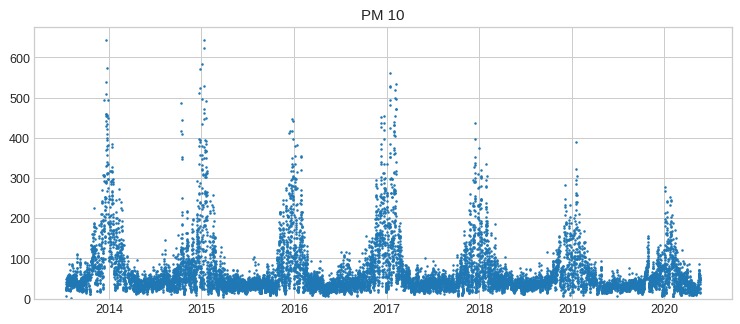

In [3]:
fig = plt.figure(figsize=(10, 4), dpi=90)
plt.scatter(data.time, data.pm10,
            marker='.', s=4)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().set(title='PM 10', ylim=(0, None))
None

<AxesSubplot:xlabel='y'>

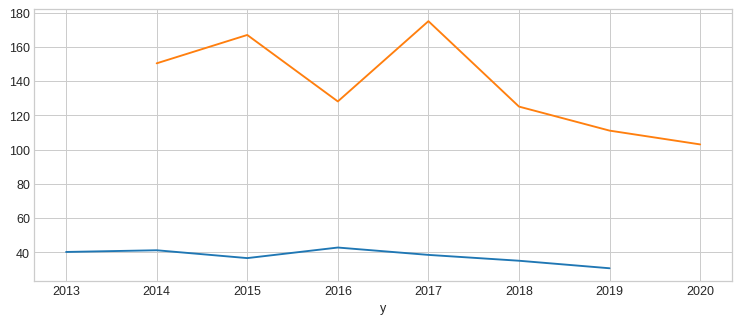

In [4]:
fig = plt.figure(figsize=(10, 4), dpi=90)
tmp = data.assign(y = data.time.dt.year)
tmp[tmp.time.dt.month == 7].groupby('y').pm10.mean().plot()
tmp[tmp.time.dt.month == 1].groupby('y').pm10.mean().plot()
# tmp1.plot()
# tmp
# plt.scatter(data.time, data.pm10,
#             marker='.', s=4)
# plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
# plt.gca().set(title='PM 10', ylim=(0, None))
# None

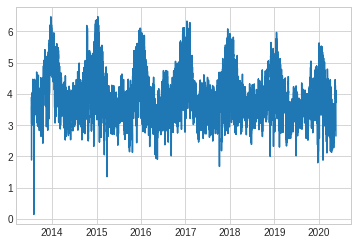

In [26]:
plt.plot(data.time, np.log(data.pm10))

## Model

We are fitting a three-component model using the slow, yearly trend, the monthly periodicity and the location of that measurment station, in the log-scale:

$$ \log pm_{10} = \overline{log(pm_{10})} + Y_{year} + M_{year, month} + P_{place} $$


The monthly effect is modeled as a product of a yearly changing magnitude $b$ and a periodical component $monthly$:


$$ M_{year, month} = (b_{year} + 1) monthly_{month} $$

The slow trend $a = Y$ and the magnitude $b$ are treated as covariates and are drawn from a hyperprior:

$$ \big(a, b \big) \sim \text{Normal}(0, \text{cholesky_covariance} = K) $$

$$ K \sim LKJCholesky(\eta = 1, \sigma \sim \text{Exponential}(2) ) $$

Them periodical component is also drawn from a hyperprior:

$$ monthly \sim \text{Normal}(0, \sigma_{m}) $$

$$ \sigma_m \sim \text{Exponential}(1) $$

The location has a similar threatment:

$$ P \sim Normal(0, \sigma_p) $$

$$ \sigma_P \sim \text{Exponential}(1) $$

Finally, for the likelihood of the inference we use log-normal, as it appears that the top-end tails are wider where the variance is bigger. Also, we use a separate variance for each month:

$$ \text{observed} \sim \text{Lognormal}(\log{pm_{10}}, \theta_{month}) $$

$$ \theta \sim \text{Exponential}(1) $$

0        197
1        197
2        197
3        197
4        197
        ... 
12904    141
12905    142
12906    142
12907    142
12908    142
Name: time, Length: 12909, dtype: int64

In [86]:
t_i = (data.time - data.time.min()).dt.days.values
# month_i = data.time.dt.month.values - 1
doy_i = data.time.dt.dayofyear -1

with pm.Model() as m1:
    n = t_i.max() + 1
    a = pm.Normal('a', 0, 2)
    b = pm.Normal('b', 0, 2)

#     step = pm.Exponential('step', 1/0.00001)
#     step = 1e-6
#     t = pm.GaussianRandomWalk('t', init=pm.Normal.dist(0, 2), sigma=step, shape=n)

#     step2 = pm.Exponential('step2', 1/.00001)
#     logM = pm.GaussianRandomWalk('logM', sigma=step2, shape=n)
#     M = pm.Deterministic('M', pm.math.exp(logM))

    # monthly effect
#     month_bar = pm.Exponential('month_bar', lam=1)
    raw_monthly = pm.Normal('raw_monthly', mu=0, sd=1, shape=366)

    # location effect
#     place_bar = pm.Exponential('place_bar', lam=1)
#     place = pm.Normal('place', mu=0, sd=place_bar,
#                       shape=data.place_i.nunique())

    avg_log_pm10 = pm.Deterministic('avg_log_pm10', 
#         t[t_i]
        3 + a + b * t_i
        + raw_monthly[doy_i]
    )

    log_pm10 = pm.Deterministic(
        'log_pm10',
        avg_log_pm10
#         + place[data.place_i.values]
    )

    # variable volatility
    sigma = pm.HalfCauchy('sigma', 1)

    # inference
    pm.Lognormal('obs', mu=log_pm10, sigma=sigma,
                 observed=data.pm10.values)

    pm10 = pm.Deterministic('pm10', pm.math.exp(avg_log_pm10 + sigma**2/2.))

    m1.trace = pm.sample(3000, tune=500, chains=2, )
#     m1.map = pm.find_MAP()

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, raw_monthly, b, a]


RuntimeError: Chain 1 failed.

In [ ]:
m1.map

In [ ]:
plt.plot(range(n), m1.map['t'])

In [ ]:
plt.plot(data.time, m1.map['avg_log_pm10'])

In [ ]:
pm.summary(m1.trace, var_names=['raw_monthly'])

In [44]:
# with pm.Model() as m1:
#     n_months = data.month_i.max() + 1

# #     step = pm.Exponential('step', 1)
#     step = 0.01
#     t = pm.GaussianRandomWalk('t', sigma=step, shape=n_months)
# #     logM = pm.GaussianRandomWalk('logM', sigma=step[1], shape=n_months)
# #     M = pm.Deterministic('M', pm.math.exp(logM))

#     # monthly effect
# #     month_bar = pm.Exponential('month_bar', lam=1)
#     raw_monthly = pm.Normal('raw_monthly', mu=0, sd=1, shape=12)

#     # location effect
#     place_bar = pm.Exponential('place_bar', lam=1)
#     place = pm.Normal('place', mu=0, sd=place_bar,
#                       shape=data.place_i.nunique())

#     avg_log_pm10 = (
#         np.log(data[data.time.dt.month == 7].pm10).mean()
#         + t[data.month_i.values]
# #         + M[data.month_i.values]
#         + monthly[data.time.dt.month.values - 1]
#     )

#     log_pm10 = pm.Deterministic(
#         'log_pm10',
#         avg_log_pm10 + place[data.place_i.values]
#     )

#     # variable volatility
# #     sigma = pm.Exponential('sigma', lam=1, shape=12)
# #     sigma_i = sigma[data.time.dt.month.values - 1]
#     sigma_i = pm.HalfCauchy('sigma', 1)

#     # inference
#     pm.Lognormal('obs', mu=log_pm10, sigma=sigma_i,
#                  observed=data.pm10.values)

#     pm10 = pm.Deterministic('pm10', pm.math.exp(avg_log_pm10 + sigma_i/2.))

#     m1.trace = pm.sample(3000, tune=500, chains=2, )
# #     m1.map = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, place, place_bar, monthly, t]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [16:31<00:00,  8.07draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


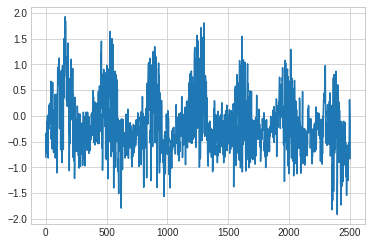

In [33]:
tmp = pd.DataFrame(pm.hpd(m1.trace['t']))
tmp = tmp.assign(mean_ = m1.trace['t'].mean(axis=0))


plt.plot(range(n), tmp.mean_)


/home/petrushev/etc/jup_venv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


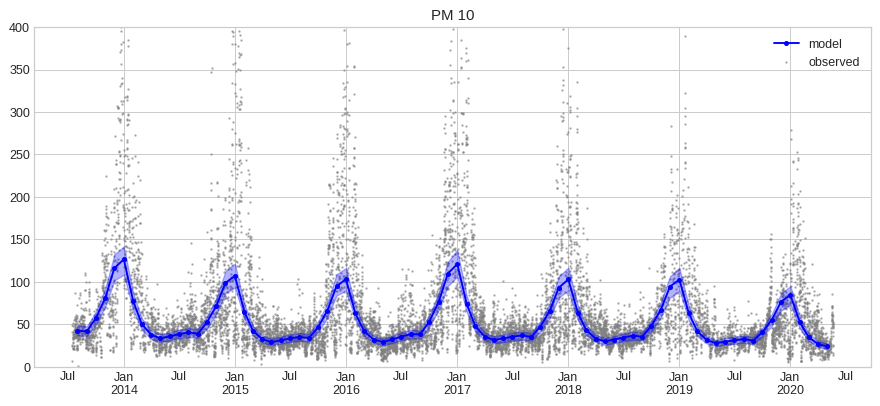

In [58]:
tr = np.exp(np.log(m1.trace['pm10']) - m1.trace['sigma'].reshape(-1, 1) / 2)

tmp = pd.DataFrame(pm.hpd(tr)).join(data.time.to_frame())
tmp = tmp.assign(mean_ = tr.mean(axis=0))
tmp = tmp[tmp.time.dt.day == 1]
tmp = tmp.drop_duplicates().sort_values('time').reset_index(drop=True)

fig = plt.figure(figsize=(12, 5), dpi=90)

plt.scatter(data.time, data.pm10,
            marker='.', alpha=.5, s=4, color='gray', label='observed')
plt.plot(tmp.time, tmp.mean_, label='model',
            marker='.', color='b')
plt.fill_between(tmp.time, tmp[0], tmp[1],
                 color='b', alpha=.3)

plt.gca().xaxis.set(
    major_formatter = DateFormatter('%b\n%Y'),
    minor_formatter = DateFormatter('%b'),
    minor_locator = MonthLocator(bymonth=[1, 7]),
    major_locator = YearLocator(month=1)
)
plt.gca().set(title='PM 10',
              ylim=(0, 400)
)
plt.legend()
None

In [133]:
with pm.Model() as m2:
    n_months = data.month_i.max() + 1

    step = 0.02
    logM = pm.GaussianRandomWalk('logM', sigma=step, shape=n_months)
    M = pm.Deterministic('M', pm.math.exp(logM))

    # monthly effect
    raw_monthly = pm.Beta('raw_monthly', 1, 1, shape=12)

    monthly = pm.Deterministic(
        'monthly',
        (raw_monthly - raw_monthly[4])
        / (0.0001 + raw_monthly[0] - raw_monthly[4])
    )
    
    # location effect
    place_bar = pm.Exponential('place_bar', lam=1)
    place = pm.Normal('place', mu=0, sd=place_bar,
                      shape=data.place_i.nunique())

    a = pm.Normal('a', 0, 1)

    avg_log_pm10 = (
        np.log(data.pm10).mean()
        + a 
        + M[data.month_i.values]
            * monthly[data.time.dt.month.values - 1]
    )

    log_pm10 = pm.Deterministic(
        'log_pm10',
        avg_log_pm10 + place[data.place_i.values]
    )

    # variable volatility
    sigma = pm.HalfCauchy('sigma', 1)

    # inference
    pm.Lognormal('obs', mu=log_pm10, sigma=sigma,
                 observed=data.pm10.values)

    pm10 = pm.Deterministic('pm10', pm.math.exp(avg_log_pm10))
    trend = pm.Deterministic(
        'trend',
        pm.math.exp(
            np.log(data.pm10).mean()
            + a 
            + M * 1
        )
    )

    m2.trace = pm.sample(2000, tune=1000, chains=2)
#     m2.map = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, place, place_bar, raw_monthly, logM]
Sampling 2 chains, 263 divergences: 100%|██████████| 6000/6000 [09:05<00:00, 10.99draws/s]
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6922423710972069, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


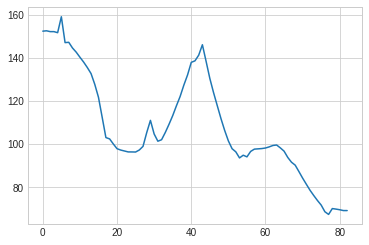

In [129]:
plt.plot(m2.map['trend'])

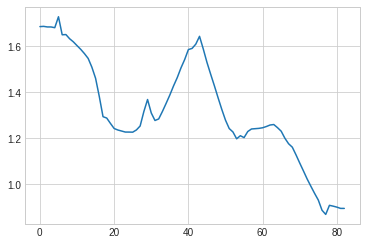

In [130]:
plt.plot(m2.map['M'])

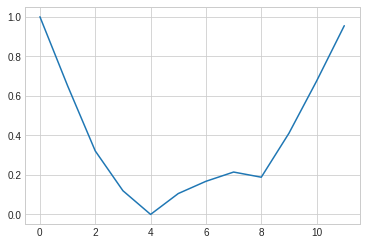

In [131]:
plt.plot(m2.map['monthly'])

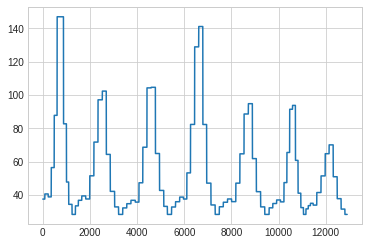

In [132]:
plt.plot(m2.map['pm10'])

/home/petrushev/etc/jup_venv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


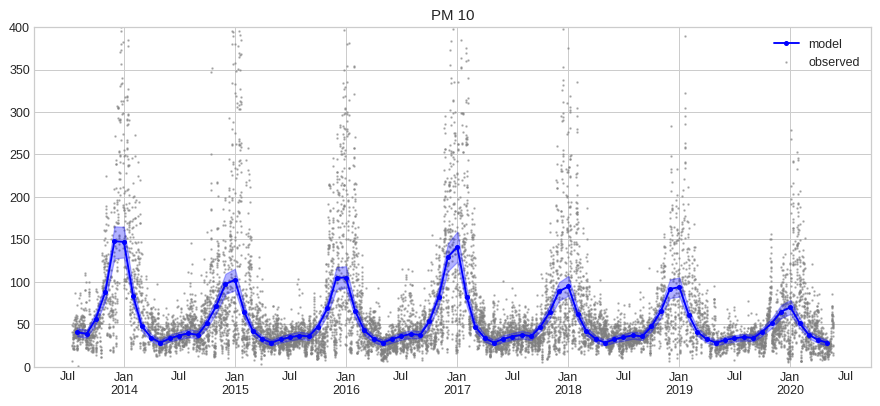

In [139]:
tmp = pd.DataFrame(pm.hpd(m2.trace['pm10'])).join(data.time.to_frame())
tmp = tmp.assign(mean_ = m2.trace['pm10'].mean(axis=0))
tmp = tmp[tmp.time.dt.day == 1]
tmp = tmp.drop_duplicates().sort_values('time').reset_index(drop=True)

fig = plt.figure(figsize=(12, 5), dpi=90)

plt.scatter(data.time, data.pm10,
            marker='.', alpha=.5, s=4, color='gray', label='observed')
plt.plot(tmp.time, tmp.mean_, label='model',
            marker='.', color='b')
plt.fill_between(tmp.time, tmp[0], tmp[1],
                 color='b', alpha=.3)

plt.gca().xaxis.set(
    major_formatter = DateFormatter('%b\n%Y'),
    minor_formatter = DateFormatter('%b'),
    minor_locator = MonthLocator(bymonth=[1, 7]),
    major_locator = YearLocator(month=1)
)
plt.gca().set(title='PM 10',
              ylim=(0, 400)
)
plt.legend()
None

/home/petrushev/etc/jup_venv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/petrushev/etc/jup_venv/lib/python3.8/site-packages/arviz/data/base.py:141: UserWarning: More chains (4000) than draws (83). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,0,1,time,mean_
0,126.550842,180.004267,2013-07-16,152.802478
1,127.114409,178.232953,2013-08-01,153.009395
2,129.344388,177.279273,2013-09-01,152.520946
3,130.058150,174.698462,2013-10-01,152.450471
4,130.304193,171.698434,2013-11-01,151.681275
...,...,...,...,...
78,62.200000,78.738246,2020-01-01,70.094055
79,61.691480,78.737160,2020-02-01,69.853798
80,61.373525,78.559338,2020-03-01,69.558259
81,60.766242,78.475488,2020-04-01,69.232635


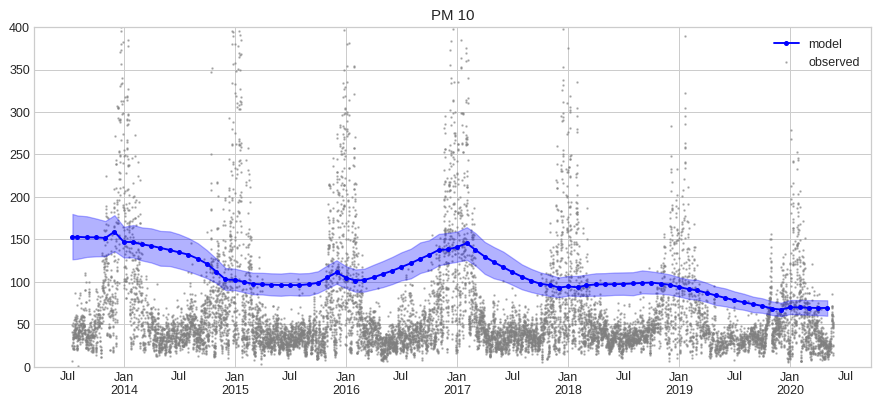

In [143]:
time_idx = data[['month_i', 'time']]
time_idx = time_idx.groupby('month_i').time.min().sort_index()


tmp = pd.DataFrame(pm.hpd(m2.trace['trend'])).join(time_idx)
tmp = tmp.assign(mean_ = m2.trace['trend'].mean(axis=0))
tmp = tmp.drop_duplicates().sort_values('time')

fig = plt.figure(figsize=(12, 5), dpi=90)

plt.scatter(data.time, data.pm10,
            marker='.', alpha=.5, s=4, color='gray', label='observed')
plt.plot(tmp.time, tmp.mean_, label='model',
            marker='.', color='b')
plt.fill_between(tmp.time, tmp[0], tmp[1],
                 color='b', alpha=.3)

plt.gca().xaxis.set(
    major_formatter = DateFormatter('%b\n%Y'),
    minor_formatter = DateFormatter('%b'),
    minor_locator = MonthLocator(bymonth=[1, 7]),
    major_locator = YearLocator(month=1)
)
plt.gca().set(title='PM 10',
              ylim=(0, 400)
)
plt.legend()
None
tmp

---

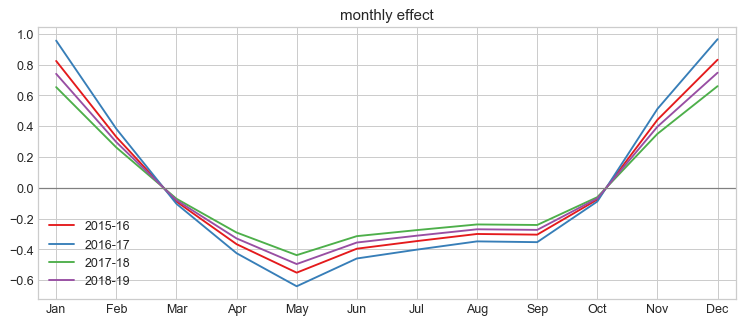

In [13]:
plt.figure(figsize=(10, 4), dpi=90)

b_year_tr = pd.DataFrame(m1.trace['b_year']).apply(summarize()).T.mean_.values.reshape(-1, 1)
monthly_tr = pd.DataFrame(m1.trace['monthly']).apply(summarize()).T.mean_

for sub, l, c in zip((b_year_tr * monthly_tr.values.reshape(1, -1)),
                     ['2015-16', '2016-17', '2017-18', '2018-19'],
                     Set1.colors):
    plt.plot(sub, label=l, c=c)

plt.axhline(0, linewidth=1, color='gray')

plt.gca().set(
    xticks=range(12),
    xticklabels=[month_abbr[i+1] for i in range(12)],
    title='monthly effect',
    xlim=(-0.3, 11.3)
)

plt.legend()
None

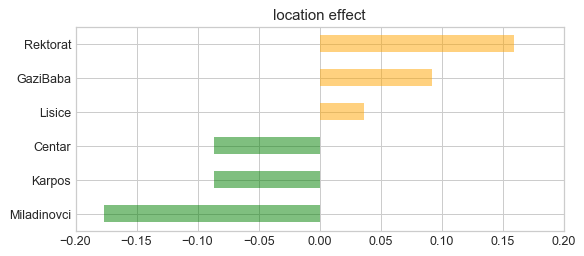

In [15]:
tmp = (
    pd.Series(m1.trace['place'].mean(axis=0), name='place_eff').to_frame()
    .join(
        data[['place', 'place_i']].drop_duplicates().set_index('place_i').sort_index()
    )
    .set_index('place')
    .place_eff.sort_values()
)

plt.figure(figsize=(7, 3), dpi=90)
ax = tmp.plot.barh(color=tmp.map(lambda x: 'orange' if x > 0 else 'g'),
                   alpha=.5)
ax.set(title='location effect', ylabel='',
       xlim=(-0.2, 0.2))
None

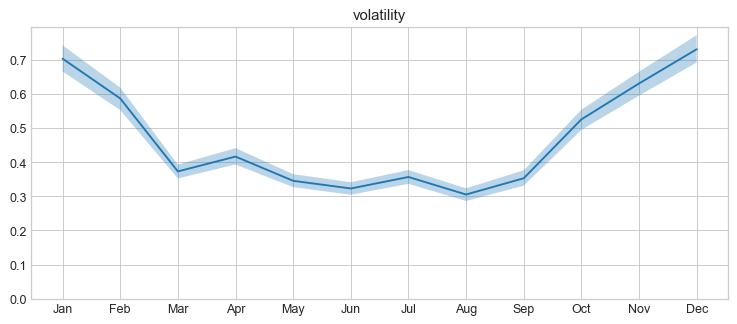

In [16]:
fig = plt.figure(figsize=(10, 4), dpi=90)

vol_tr = pd.DataFrame(m1.trace['sigma']).apply(summarize()).T

plt.plot(vol_tr.mean_)
plt.fill_between(range(12), vol_tr.lower, vol_tr.upper,
                 alpha=.3)
plt.gca().set(xticklabels=[month_abbr[i+1] for i in range(12)],
              xticks=range(12),
              title='volatility',
              ylim=(0, None))
None